# 数据规整化：清理、转换、合并、重塑

数据分析和建模大量编程工作都是用在数据准备上：加载、清理、转换、重塑。

Pandas 和 Python 标准库提供一组高级的、灵活的、高效的核心函数和算法，让人可以轻松将数据规整化为正确的形式。

In [1]:
%pylab inline

import numpy as np
from numpy.random import randn

import pandas as pd
from pandas import Series, DataFrame

Populating the interactive namespace from numpy and matplotlib


## 合并数据集

- pandas.merge 可根据一个或多个建将不同 DataFrame 中的行连接起来。类似关系型数据库的连接操作（join）
- pandas.concat 可以沿一条轴将多个对象堆叠在一起

### 数据库风格的 DataFrame 合并

In [2]:
df1 = DataFrame({'key': list('bbacaab'), 'data1': range(7)})
df2 = DataFrame({'key': list('abd'), 'data2': range(3)})

# 重叠列的列名当键
pd.merge(df1, df2)

,data1,key,data2
0,0,b,1
1,1,b,1
2,6,b,1
3,2,a,0
4,4,a,0
5,5,a,0


In [3]:
df3 = DataFrame({'lkey': list('bbacaab'), 'data1': range(7)})
df4 = DataFrame({'rkey': list('abd'), 'data2': range(3)})

In [4]:
# 指定键
pd.merge(df3, df4, left_on='lkey', right_on='rkey')

,data1,lkey,data2,rkey
0,0,b,1,b
1,1,b,1,b
2,6,b,1,b
3,2,a,0,a
4,4,a,0,a
5,5,a,0,a


In [5]:
# outer 外连接求取键的并集
pd.merge(df3, df4, left_on='lkey', right_on='rkey', how='outer')

,data1,lkey,data2,rkey
0,0.0,b,1.0,b
1,1.0,b,1.0,b
2,6.0,b,1.0,b
3,2.0,a,0.0,a
4,4.0,a,0.0,a
5,5.0,a,0.0,a
6,3.0,c,NaN,NaN
7,NaN,NaN,2.0,d


In [6]:
# left join
pd.merge(df1, df2, how='left')

,data1,key,data2
0,0,b,1.0
1,1,b,1.0
2,2,a,0.0
3,3,c,NaN
4,4,a,0.0
5,5,a,0.0
6,6,b,1.0


In [7]:
# inner join
pd.merge(df1, df2, how='inner')

,data1,key,data2
0,0,b,1
1,1,b,1
2,6,b,1
3,2,a,0
4,4,a,0
5,5,a,0


In [8]:
left = DataFrame({
    'key1': ['foo','foo','bar'],
    'key2': ['one','two','one'],
    'lval': [1,2,3]
})
right = DataFrame({
    'key1': ['foo','foo','bar','bar'],
    'key2': ['one','one','one','two'],
    'lval': [4,5,6,7]
})

# 根据多个键进行合并
pd.merge(left, right, on=['key1','key2'], how='outer')

,key1,key2,lval_x,lval_y
0,foo,one,1.0,4.0
1,foo,one,1.0,5.0
2,foo,two,2.0,NaN
3,bar,one,3.0,6.0
4,bar,two,NaN,7.0


In [9]:
# 合并出现重复 column
pd.merge(left, right, on='key1')

,key1,key2_x,lval_x,key2_y,lval_y
0,foo,one,1,one,4
1,foo,one,1,one,5
2,foo,two,2,one,4
3,foo,two,2,one,5
4,bar,one,3,one,6
5,bar,one,3,two,7


In [10]:
# 自定义重复列名
pd.merge(left, right, on='key1', suffixes=('_left', '_right'))

,key1,key2_left,lval_left,key2_right,lval_right
0,foo,one,1,one,4
1,foo,one,1,one,5
2,foo,two,2,one,4
3,foo,two,2,one,5
4,bar,one,3,one,6
5,bar,one,3,two,7


merge 函数的参数

参数 | 说明
---|---
`left` | 参与合并的左侧 DataFrame
`right` | 参与合并的右侧 DataFrame
`how` | `inner`, `outer`, `left`, `right`，默认为 `inner` 
`on` | 用于连接的列名
`left_on` | 左侧 DataFrame 中用作连接键的 column
`right_on` | 右侧 DataFrame 中用作连接键的 column
`left_index` | 将左侧的行索引用作其连接键
`right_index` | 将右侧的行索引用作其连接键
`sort` | 根据连接键对合并后的数据进行排序，默认为 True
`suffixes` | 字符串值 tuple，用于追加重叠 column 的末尾 
`copy` | 设置为 False。某些特殊情况下避免将数据复制到结果数据结构中

### 索引上的合并

In [11]:
left = DataFrame({'key': list('abaabc'), 'value': range(6)})
right = DataFrame({'group_val': [3.5, 7]}, index=['a','b'])

# 使用 left_index, right_index 说明索引当做连接键
pd.merge(left, right, left_on='key', right_index=True)

,key,value,group_val
0,a,0,3.5
2,a,2,3.5
3,a,3,3.5
1,b,1,7.0
4,b,4,7.0


In [12]:
# 指定键
left.join(right, on='key')

,key,value,group_val
0,a,0,3.5
1,b,1,7.0
2,a,2,3.5
3,a,3,3.5
4,b,4,7.0
5,c,5,NaN


In [13]:
# 层次化数据
left = DataFrame({
    'key1': ['A', 'A', 'A', 'B', 'B'],
    'key2': [0, 1, 2, 1, 2],
    'data': np.arange(5)})
right = DataFrame(
    np.arange(12).reshape((6, 2)),
    index=[['B', 'B', 'A', 'A', 'A', 'A'],[1, 0, 0, 0, 1, 2]],
    columns=['event1', 'event2'])

# 使用多重索引
pd.merge(left, right, left_on=['key1','key2'], right_index=True)

,data,key1,key2,event1,event2
0,0,A,0,4,5
0,0,A,0,6,7
1,1,A,1,8,9
2,2,A,2,10,11
3,3,B,1,0,1


In [14]:
left = DataFrame([[1, 2], [3, 4], [5, 6]],
                 index=['a', 'c', 'e'],
                 columns=['Ohio', 'Nevada'])

right = DataFrame([[7, 8], [9, 10], [11, 12], [13, 14]],
                  index=['b', 'c', 'd', 'e'],
                  columns=['Missouri', 'Alabama'])

# 合并索引
pd.merge(left, right, how='outer', left_index=True, right_index=True)

,Ohio,Nevada,Missouri,Alabama
a,1.0,2.0,NaN,NaN
b,NaN,NaN,7.0,8.0
c,3.0,4.0,9.0,10.0
d,NaN,NaN,11.0,12.0
e,5.0,6.0,13.0,14.0


In [15]:
# 使用 join 实例方法
left.join(right, how='outer')

,Ohio,Nevada,Missouri,Alabama
a,1.0,2.0,NaN,NaN
b,NaN,NaN,7.0,8.0
c,3.0,4.0,9.0,10.0
d,NaN,NaN,11.0,12.0
e,5.0,6.0,13.0,14.0


In [16]:
another = DataFrame([[7, 8], [9, 10], [11, 12], [16, 17]],
                    index=['a', 'c', 'e', 'f'], 
                    columns=['New York', 'Oregon'])

# 向join传入一组DataFrame
left.join([right, another])

,Ohio,Nevada,Missouri,Alabama,New York,Oregon
a,1,2,NaN,NaN,7,8
c,3,4,9.0,10.0,9,10
e,5,6,13.0,14.0,11,12


### 轴向连接

In [17]:
arr = np.arange(12).reshape((3,4))
arr

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11]])

In [18]:
# 沿着 index 轴连接 （预设）
np.concatenate([arr,arr])

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11],
       [ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11]])

In [19]:
# 沿着 column 轴连接
np.concatenate([arr,arr], axis=1)

array([[ 0,  1,  2,  3,  0,  1,  2,  3],
       [ 4,  5,  6,  7,  4,  5,  6,  7],
       [ 8,  9, 10, 11,  8,  9, 10, 11]])

In [20]:
s1 = Series([0,1], index=['a','b'])
s2 = Series([2,3,4], index=['c','d','e'])
s3 = Series([5,6], index=['f','g'])

# 沿着 index 轴连接
pd.concat([s1,s2,s3])

a    0
b    1
c    2
d    3
e    4
f    5
g    6
dtype: int64

In [21]:
# 沿着 column 轴连接，变成一个 DataFrame
pd.concat([s1,s2,s3], axis=1)

,0,1,2
a,0.0,NaN,NaN
b,1.0,NaN,NaN
c,NaN,2.0,NaN
d,NaN,3.0,NaN
e,NaN,4.0,NaN
f,NaN,NaN,5.0
g,NaN,NaN,6.0


In [22]:
s4 = pd.concat([s1*5, s3])

# 取合并的交集
pd.concat([s1, s4], axis=1, join='inner')

,0,1
a,0,0
b,1,5


In [23]:
# 使用 key 参数在连接轴上创建一个层次化索引
result = pd.concat([s1,s2,s3], keys=['one','two','three'])
result

one    a    0
       b    1
two    c    2
       d    3
       e    4
three  f    5
       g    6
dtype: int64

In [24]:
result.unstack()

,a,b,c,d,e,f,g
one,0.0,1.0,NaN,NaN,NaN,NaN,NaN
two,NaN,NaN,2.0,3.0,4.0,NaN,NaN
three,NaN,NaN,NaN,NaN,NaN,5.0,6.0


In [25]:
# 沿着axis=1对Series合并，keys变成DataFrame的列头
pd.concat([s1,s2,s3], axis=1, keys=['one','two','three'])

,one,two,three
a,0.0,NaN,NaN
b,1.0,NaN,NaN
c,NaN,2.0,NaN
d,NaN,3.0,NaN
e,NaN,4.0,NaN
f,NaN,NaN,5.0
g,NaN,NaN,6.0


In [26]:
df1 = DataFrame(np.arange(6).reshape(3, 2), 
                index=['a', 'b', 'c'],
                columns=['one', 'two'])

df2 = DataFrame(5 + np.arange(4).reshape(2, 2), 
                index=['a', 'c'], 
                columns=['three', 'four'])

In [27]:
# 沿着axis=1对DataFrame合并
pd.concat([df1, df2], axis=1, keys=['group1','group2'])

group1     group2     
     one two  three four
a      0   1    5.0  6.0
b      2   3    NaN  NaN
c      4   5    7.0  8.0

In [28]:
pd.concat({'group1': df1, 'group2': df2}, axis=1)

group1     group2     
     one two  three four
a      0   1    5.0  6.0
b      2   3    NaN  NaN
c      4   5    7.0  8.0

In [29]:
# 管理层次化索引的创建方式
pd.concat([df1, df2], axis=1, keys=['group1','group2'],
         names=['upper', 'lower'])

upper group1     group2     
lower    one two  three four
a          0   1    5.0  6.0
b          2   3    NaN  NaN
c          4   5    7.0  8.0

In [30]:
df1 = DataFrame(np.random.randn(3, 4), columns=['a', 'b', 'c', 'd'])
df2 = DataFrame(np.random.randn(2, 3), columns=['b', 'd', 'a'])

# 不保留连接轴上的索引
pd.concat([df1, df2], ignore_index=True)

,a,b,c,d
0,-1.691117,-0.336092,1.636428,1.205965
1,1.257137,-1.102485,0.342434,-0.308891
2,0.188080,0.009262,-0.538618,-0.838533
3,0.671147,-0.554439,NaN,1.220312
4,-1.313892,0.023230,NaN,0.406764


concat 函数的参数

参数 | 说明
---|---
`objs` | 参与连接的pandas对象的列表或字典
`axis` | 指明连接的轴向
`join` | `inner`, `outer` 其中之一
`join_axes` | 指明用于其他 n-1 条轴的索引，不执行并集、交集运算
`keys` | 与连接对象有关的值，用于形成连接轴向上的层次化索引
`levels` | 指定用作层次化索引各级上的索引
`names` | 用于创建分层级别的名称
`verify_integrity` | 检查结果对象新轴上的重复情况，如果发现则引发异常。默认 False
`ignore_index` | 不保留连接轴上的索引，产生一组新索引 range

### Combining Data with Overlap

In [31]:
a = Series([np.nan, 2.5, np.nan, 3.5, 4.5, np.nan], index=['f', 'e', 'd', 'c', 'b', 'a'])
b = Series(np.arange(len(a), dtype=np.float64), index=['f', 'e', 'd', 'c', 'b', 'a'])
b[-1] = np.nan

In [32]:
# 选择性合并
np.where(pd.isnull(a), b, a)

array([ 0. ,  2.5,  2. ,  3.5,  4.5,  nan])

In [33]:
# Series.combine_first 合并，且进行数据对齐
b[:-2].combine_first(a[2:])

a    NaN
b    4.5
c    3.0
d    2.0
e    1.0
f    0.0
dtype: float64

In [34]:
df1 = DataFrame({'a': [1., np.nan, 5., np.nan], 
                 'b': [np.nan, 2., np.nan, 6.],
                 'c': range(2, 18, 4)})
df2 = DataFrame({'a': [5., 4., np.nan, 3., 7.], 
                 'b': [np.nan, 3., 4., 6., 8.]})

In [35]:
# 用参数对象中的数据为调用者对象的缺失数据“打补丁”
df1.combine_first(df2)

,a,b,c
0,1.0,NaN,2.0
1,4.0,2.0,6.0
2,5.0,4.0,10.0
3,3.0,6.0,14.0
4,7.0,8.0,NaN


## Reshaping and Pivoting
### Reshaping with Hierarchical Indexing
- `stack`：将数据的 column “旋转”为 row
- `unstack`：将数据的 row “旋转”为 column

In [36]:
data = DataFrame(np.arange(6).reshape((2, 3)),
                 index=pd.Index(['Ohio', 'Colorado'], name='state'),
                 columns=pd.Index(['one', 'two', 'three'], name='number'))
data

number,one,two,three
state,,,
Ohio,0,1,2
Colorado,3,4,5


In [37]:
result = data.stack()
result

state     number
Ohio      one       0
          two       1
          three     2
Colorado  one       3
          two       4
          three     5
dtype: int64

In [38]:
result.unstack()

number,one,two,three
state,,,
Ohio,0,1,2
Colorado,3,4,5


In [39]:
df = DataFrame({'left': result, 'right': result + 5},
              columns=pd.Index(['left', 'right'], name='side'))
df

side             left  right
state    number             
Ohio     one        0      5
         two        1      6
         three      2      7
Colorado one        3      8
         two        4      9
         three      5     10

In [40]:
# 进行 stack 操作，作为旋转轴的级别会成为结果中的最低级别（最内层）
df.stack()

state     number  side 
Ohio      one     left      0
                  right     5
          two     left      1
                  right     6
          three   left      2
                  right     7
Colorado  one     left      3
                  right     8
          two     left      4
                  right     9
          three   left      5
                  right    10
dtype: int64

In [41]:
# 进行 unstack 操作，作为旋转轴的级别会成为结果中的最低级别（最内层）
df.unstack('state')

side   left          right         
state  Ohio Colorado  Ohio Colorado
number                             
one       0        3     5        8
two       1        4     6        9
three     2        5     7       10

In [42]:
# unstack、stack 指定旋转轴
df.unstack('state').stack('side')

state         Ohio  Colorado
number side                 
one    left      0         3
       right     5         8
two    left      1         4
       right     6         9
three  left      2         5
       right     7        10

In [43]:
# 把 state 放到外层
df.stack().unstack(0).unstack(1)

state  Ohio       Colorado      
side   left right     left right
number                          
one       0     5        3     8
two       1     6        4     9
three     2     7        5    10

### Pivoting “long” to “wide” Format

时间序列数据通常是以所谓的长格式（long）或堆叠格式（stacked）存储在数据库和CSV中。

In [44]:
ldata = DataFrame({
    'date': ['1959-03-31']*3 + ['1959-06-30']*3 + ['1959-09-30']*3 + ['1959-12-31']*3,
    'item': ['R','I','U']*4,
    'value': [2710.349, 0, 5.8, 2778.801, 2.34, 5.1, 2775.488, 2.74, 5.3, 2785.204, 2.66, 5.12]
})

ldata

,date,item,value
0,1959-03-31,R,2710.349
1,1959-03-31,I,0.000
2,1959-03-31,U,5.800
3,1959-06-30,R,2778.801
4,1959-06-30,I,2.340
5,1959-06-30,U,5.100
6,1959-09-30,R,2775.488
7,1959-09-30,I,2.740
8,1959-09-30,U,5.300
9,1959-12-31,R,2785.204


关系数据库的数据经常都是这样存储的，因为固定架构（列名和数据类型）有个好处：随着表中数据的添加或删除，item列中的值的种类能够增加或减少。

上面的例子中，date和item通常就是主键（RDBMS的说法），不仅提供了关系完整性，而且提供了更为简单的查询支持。当然也是有缺点：长格式的数据操作比DataFrame麻烦。

所以把不同的item值形成一个列，date列中的时间值当做索引。DataFrame pivot 方法可以实现这个转换。

In [45]:
# DataFrame.pivot(index, columns, values)
# 前两个参数分别用作焊合咧索引的列名；最后一个参数由于填充DataFrame数据列的列名
ldata.pivot('date', 'item', 'value')

item,I,R,U
date,,,
1959-03-31,0.00,2710.349,5.80
1959-06-30,2.34,2778.801,5.10
1959-09-30,2.74,2775.488,5.30
1959-12-31,2.66,2785.204,5.12


In [46]:
# 假设有两个需要参与重塑的数据列 (value, value2)
ldata['value2'] = np.random.randn(len(ldata))
ldata

,date,item,value,value2
0,1959-03-31,R,2710.349,-1.376900
1,1959-03-31,I,0.000,-0.314694
2,1959-03-31,U,5.800,-1.287771
3,1959-06-30,R,2778.801,-1.301504
4,1959-06-30,I,2.340,-0.098578
5,1959-06-30,U,5.100,-0.741931
6,1959-09-30,R,2775.488,0.883663
7,1959-09-30,I,2.740,2.061163
8,1959-09-30,U,5.300,0.566023
9,1959-12-31,R,2785.204,0.116461


In [47]:
# 忽略最后一个参数，得到DataFrame就会带有层次的列
ldata.pivot('date', 'item')

value                    value2                    
item           I         R     U         I         R         U
date                                                          
1959-03-31  0.00  2710.349  5.80 -0.314694 -1.376900 -1.287771
1959-06-30  2.34  2778.801  5.10 -0.098578 -1.301504 -0.741931
1959-09-30  2.74  2775.488  5.30  2.061163  0.883663  0.566023
1959-12-31  2.66  2785.204  5.12 -0.223343  0.116461  0.298841

In [48]:
# pivot 只是一种快捷方式，用set_index创建层次化索引、再用unstack
ldata.set_index(['date', 'item']).unstack('item')

value                    value2                    
item           I         R     U         I         R         U
date                                                          
1959-03-31  0.00  2710.349  5.80 -0.314694 -1.376900 -1.287771
1959-06-30  2.34  2778.801  5.10 -0.098578 -1.301504 -0.741931
1959-09-30  2.74  2775.488  5.30  2.061163  0.883663  0.566023
1959-12-31  2.66  2785.204  5.12 -0.223343  0.116461  0.298841

## Data Transformation
### Removing Duplicates

In [49]:
data = DataFrame({'k1': ['one'] * 3 + ['two'] * 4, 'k2': [1, 1, 2, 3, 3, 4, 4]})
data

,k1,k2
0,one,1
1,one,1
2,one,2
3,two,3
4,two,3
5,two,4
6,two,4


In [50]:
data.duplicated()

0    False
1     True
2    False
3    False
4     True
5    False
6     True
dtype: bool

In [51]:
data.drop_duplicates()

,k1,k2
0,one,1
2,one,2
3,two,3
5,two,4


In [52]:
data['v1'] = range(7)
data

,k1,k2,v1
0,one,1,0
1,one,1,1
2,one,2,2
3,two,3,3
4,two,3,4
5,two,4,5
6,two,4,6


In [53]:
# 指定部分 column 进行重复项判断，并保留之后一个
data.drop_duplicates(['k1','k2'], keep='last')

,k1,k2,v1
1,one,1,1
2,one,2,2
4,two,3,4
6,two,4,6


### Transforming Data Using a Function or Mapping

In [54]:
data = DataFrame({
    'food': ['bacon', 'pulled pork', 'bacon', 'Pastrami', 'corned beef', 'Bacon', 'pastrami', 'honey ham','nova lox'],
    'ounces': [4, 3, 12, 6, 7.5, 8, 3, 5, 6]})
data

,food,ounces
0,bacon,4.0
1,pulled pork,3.0
2,bacon,12.0
3,Pastrami,6.0
4,corned beef,7.5
5,Bacon,8.0
6,pastrami,3.0
7,honey ham,5.0
8,nova lox,6.0


In [55]:
meat_to_animal = {'bacon': 'pig', 'pulled pork': 'pig', 'pastrami': 'cow', 'corned beef': 'cow', 'honey ham': 'pig', 'nova lox': 'salmon'}

# 使用 map 映射字典对象
data['animal'] = data['food'].map(str.lower).map(meat_to_animal)
data

,food,ounces,animal
0,bacon,4.0,pig
1,pulled pork,3.0,pig
2,bacon,12.0,pig
3,Pastrami,6.0,cow
4,corned beef,7.5,cow
5,Bacon,8.0,pig
6,pastrami,3.0,cow
7,honey ham,5.0,pig
8,nova lox,6.0,salmon


In [56]:
data['food'].map(lambda x: meat_to_animal[x.lower()])

0       pig
1       pig
2       pig
3       cow
4       cow
5       pig
6       cow
7       pig
8    salmon
Name: food, dtype: object

### Replacing Values

In [57]:
data = Series([1, -999, 2, -999, -1000, 3])

# 把 -999 当成缺失数据的标记值
data.replace(-999, np.nan)

0       1.0
1       NaN
2       2.0
3       NaN
4   -1000.0
5       3.0
dtype: float64

In [58]:
# 一次替换多个值
data.replace([-999, -1000], np.nan)

0    1.0
1    NaN
2    2.0
3    NaN
4    NaN
5    3.0
dtype: float64

In [59]:
# 这对不同值进行不同替换
data.replace([-999, -1000], [np.nan, 0])

0    1.0
1    NaN
2    2.0
3    NaN
4    0.0
5    3.0
dtype: float64

In [60]:
# 使用字典当参数
data.replace({-999: np.nan, -1000: 0})

0    1.0
1    NaN
2    2.0
3    NaN
4    0.0
5    3.0
dtype: float64

In [61]:
np.where(data <= -999, np.nan, data)

array([  1.,  nan,   2.,  nan,  nan,   3.])

### Renaming Axis Indexes

In [62]:
data = DataFrame(np.arange(12).reshape((3,4)),
                index=['Ohio', 'Colorado', 'New York'],
                columns=['one','two','three','four'])
data

,one,two,three,four
Ohio,0,1,2,3
Colorado,4,5,6,7
New York,8,9,10,11


In [63]:
# 对轴标签使用map
data.index = data.index.map(str.upper)
data

,one,two,three,four
OHIO,0,1,2,3
COLORADO,4,5,6,7
NEW YORK,8,9,10,11


In [64]:
# 创建数据集的转换版（产生新的DataFrame）
data.rename(index=str.title, columns=str.upper)

,ONE,TWO,THREE,FOUR
Ohio,0,1,2,3
Colorado,4,5,6,7
New York,8,9,10,11


In [65]:
# rename 集合字典对象
data.rename(index={'OHIO': 'INDIANA'},
            columns={'three': 'peekkabkoo'})

,one,two,peekkabkoo,four
INDIANA,0,1,2,3
COLORADO,4,5,6,7
NEW YORK,8,9,10,11


In [66]:
# 使用 inplace 就地修改
data.rename(index={'OHIO': 'INDIANA'},
            columns={'three': 'peekkabkoo'},
            inplace=True)
data

,one,two,peekkabkoo,four
INDIANA,0,1,2,3
COLORADO,4,5,6,7
NEW YORK,8,9,10,11


### Discretization and Binning

In [67]:
ages = [20, 22, 25, 27, 21, 23, 37, 31, 61, 45, 41, 32]
bins = [18, 25, 36, 60, 100]

# 返回一个 Categories 对象，表示面元名称的字符串
cats = pd.cut(ages, bins)
cats

[(18, 25], (18, 25], (18, 25], (25, 36], (18, 25], ..., (25, 36], (60, 100], (36, 60], (36, 60], (25, 36]]
Length: 12
Categories (4, object): [(18, 25] < (25, 36] < (36, 60] < (60, 100]]

In [68]:
# 原来用 levels，变成 categories
cats.categories

Index([u'(18, 25]', u'(25, 36]', u'(36, 60]', u'(60, 100]'], dtype='object')

In [69]:
# 原来用 labels，变成 codes
cats.codes

array([0, 0, 0, 1, 0, 0, 2, 1, 3, 2, 2, 1], dtype=int8)

In [70]:
# 查看分区出现频率
pd.value_counts(cats)

(18, 25]     5
(36, 60]     3
(25, 36]     3
(60, 100]    1
dtype: int64

In [71]:
# 右侧定义为开端
# 圆括号表示开端（不包含）、方括号表示闭端（包含）
pd.cut(ages, bins, right=False)

[[18, 25), [18, 25), [25, 36), [25, 36), [18, 25), ..., [25, 36), [60, 100), [36, 60), [36, 60), [25, 36)]
Length: 12
Categories (4, object): [[18, 25) < [25, 36) < [36, 60) < [60, 100)]

In [72]:
# 设置自己的面元名称
group_names = ['Youth','YoungAdult','MiddleAged','Senior']
pd.cut(ages, bins, labels=group_names)

[Youth, Youth, Youth, YoungAdult, Youth, ..., YoungAdult, Senior, MiddleAged, MiddleAged, YoungAdult]
Length: 12
Categories (4, object): [Youth < YoungAdult < MiddleAged < Senior]

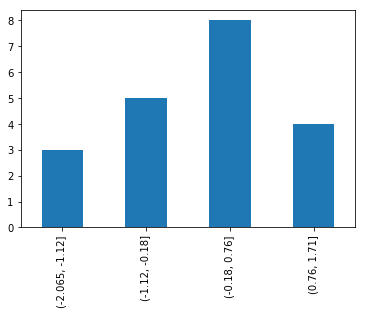

In [73]:
data = np.random.randn(20)

# 如果传入的是“数量”，则根据数据最大、最小值计算等长面元
cats = pd.cut(data, 4, precision=2)
cats.value_counts().plot(kind='bar')

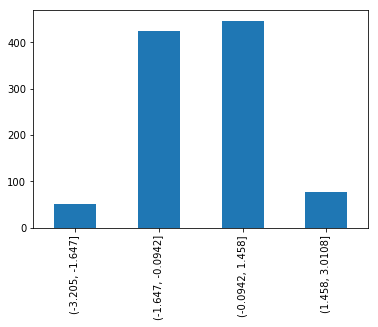

In [74]:
data = np.random.randn(1000)

# 按四分位进行切割
cats = pd.cut(data, 4)
cats.value_counts().plot(kind='bar')

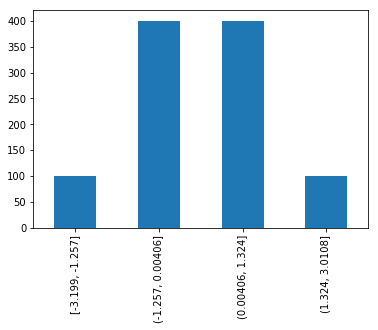

In [75]:
# 自行定义分位数
cats = pd.qcut(data, [0, 0.1, 0.5, 0.9, 1])
cats.value_counts().plot(kind='bar')

pandas.cut
- 根据面元分组，或
- 根据传入分组数量，在最小值和最大值之间划分等长面元

pandas.qcut (Quantile-based discretization function)
- 根据样本分位数对数据进行面元划分，得到样本数量相等的面元

### Detecting and Filtering Outliers

In [76]:
np.random.seed(12345)

data = DataFrame(np.random.randn(1000, 4))
data.describe()

,0,1,2,3
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,-0.067684,0.067924,0.025598,-0.002298
std,0.998035,0.992106,1.006835,0.996794
min,-3.428254,-3.548824,-3.184377,-3.745356
25%,-0.774890,-0.591841,-0.641675,-0.644144
50%,-0.116401,0.101143,0.002073,-0.013611
75%,0.616366,0.780282,0.680391,0.654328
max,3.366626,2.653656,3.260383,3.927528


In [77]:
# 想找出绝对值大于3的值
col = data[3]
col[np.abs(col) > 3]

97     3.927528
305   -3.399312
400   -3.745356
Name: 3, dtype: float64

In [78]:
# 选出任何含有“绝对值大于3的值”的row
data[(np.abs(data) > 3).any(axis=1)]

,0,1,2,3
5,-0.539741,0.476985,3.248944,-1.021228
97,-0.774363,0.552936,0.106061,3.927528
102,-0.655054,-0.565230,3.176873,0.959533
305,-2.315555,0.457246,-0.025907,-3.399312
324,0.050188,1.951312,3.260383,0.963301
400,0.146326,0.508391,-0.196713,-3.745356
499,-0.293333,-0.242459,-3.056990,1.918403
523,-3.428254,-0.296336,-0.439938,-0.867165
586,0.275144,1.179227,-3.184377,1.369891
808,-0.362528,-3.548824,1.553205,-2.186301


In [79]:
# 将“绝对值大于3的值”限制为3
data[np.abs(data) > 3] = np.sign(data) * 3
data.describe()

,0,1,2,3
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,-0.067623,0.068473,0.025153,-0.002081
std,0.995485,0.990253,1.003977,0.989736
min,-3.000000,-3.000000,-3.000000,-3.000000
25%,-0.774890,-0.591841,-0.641675,-0.644144
50%,-0.116401,0.101143,0.002073,-0.013611
75%,0.616366,0.780282,0.680391,0.654328
max,3.000000,2.653656,3.000000,3.000000


### Permutation and Random Sampling

In [80]:
df = DataFrame(np.arange(5*4).reshape(5,4))

In [81]:
# 调用 permutation 产生一个表示新顺序的整数数组
sampler = np.random.permutation(5)
sampler

array([1, 0, 2, 3, 4])

In [82]:
# 从 permutation 返回的数组中切下前k个元素，其中k为期望的子集大小
df.take(np.random.permutation(len(df))[:3])

,0,1,2,3
1,4,5,6,7
3,12,13,14,15
4,16,17,18,19


In [83]:
bag = np.array(['A','B','C','D','E'])

# 随机从五个元素，重复取出10次
sampler = np.random.randint(0, len(bag), size=10)
draws = bag.take(sampler)
draws

array(['E', 'E', 'C', 'C', 'C', 'A', 'D', 'A', 'E', 'B'], 
      dtype='|S1')

### Computing Indicator/Dummy Variables

常用于统计建模或机器学习的转换方式：将分类变量（categorical variables）转换成哑变量矩阵（dummy matrix）或指标矩阵（indicator matrix）。

如果 DataFrame 的某一列含有k个不同的值，则可以派生出一个k列矩阵或DataFrame(值为0/1)。

In [84]:
df = DataFrame({'key': list('bbacab'), 'data1': range(6)})
df

,data1,key
0,0,b
1,1,b
2,2,a
3,3,c
4,4,a
5,5,b


In [85]:
# 将分类变量（categorical variable）转换为哑变量矩阵（dummy matriex）
pd.get_dummies(df['key'])

,a,b,c
0,0,1,0
1,0,1,0
2,1,0,0
3,0,0,1
4,1,0,0
5,0,1,0


In [86]:
dummies = pd.get_dummies(df['key'], prefix='key')
df_with_dummy = df[['data1']].join(dummies)
df_with_dummy

,data1,key_a,key_b,key_c
0,0,0,1,0
1,1,0,1,0
2,2,1,0,0
3,3,0,0,1
4,4,1,0,0
5,5,0,1,0


In [87]:
movies = pd.read_table('ch02/movielens/movies.dat',
                      sep='::',
                      header=None,
                      names=['movie_id', 'title', 'genres'],
                      engine='python')

movies.head()
# genres 同属多个分类，事情有点复杂

,movie_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [88]:
# 找出所有genre
genre_iter = (set(x.split('|')) for x in movies.genres)
genres = sorted(set.union(*genre_iter))
genres

['Action',
 'Adventure',
 'Animation',
 "Children's",
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Fantasy',
 'Film-Noir',
 'Horror',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Thriller',
 'War',
 'Western']

In [89]:
# 从一个全零DataFrame开始建构指标DataFrame
dummies = DataFrame(np.zeros((len(movies), len(genres))), columns=genres)

# 迭代每部电影，根据genres设置dummies各行
for i, gen in enumerate(movies.genres):
    dummies.ix[i, gen.split('|')] = 1
    
dummies.head()

,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [90]:
movies_windic = movies.join(dummies.add_prefix('Genre_'))
movies_windic.ix[0]

movie_id                                       1
title                           Toy Story (1995)
genres               Animation|Children's|Comedy
Genre_Action                                   0
Genre_Adventure                                0
Genre_Animation                                1
Genre_Children's                               1
Genre_Comedy                                   1
Genre_Crime                                    0
Genre_Documentary                              0
Genre_Drama                                    0
Genre_Fantasy                                  0
Genre_Film-Noir                                0
Genre_Horror                                   0
Genre_Musical                                  0
Genre_Mystery                                  0
Genre_Romance                                  0
Genre_Sci-Fi                                   0
Genre_Thriller                                 0
Genre_War                                      0
Genre_Western       

In [91]:
values = np.random.rand(10)
bins = [0, 0.2, 0.4, 0.6, 0.8, 1]

# 结合 get_dummies， cut 产生离散统计数据
pd.get_dummies(pd.cut(values, bins))

,"(0, 0.2]","(0.2, 0.4]","(0.4, 0.6]","(0.6, 0.8]","(0.8, 1]"
0,0,0,0,1,0
1,0,0,0,0,1
2,0,0,0,0,1
3,1,0,0,0,0
4,0,0,0,0,1
5,0,0,0,1,0
6,1,0,0,0,0
7,0,1,0,0,0
8,0,0,0,0,1
9,0,0,1,0,0


## String Manipulation
### String Object Methods

In [92]:
val = 'a,b,  guido'

In [93]:
# 使用 split 拆分字符串
val.split(',')

['a', 'b', '  guido']

In [94]:
# 使用 strip 修剪空白符
pieces = [x.strip() for x in val.split(',')]
pieces

['a', 'b', 'guido']

In [95]:
# 使用 jion 连接字串
'::'.join(pieces)

'a::b::guido'

In [96]:
# 检测子字串
'guido' in val

True

In [97]:
# 定位子字串
val.index('guido')

6

In [98]:
# find 与 index 不同点在: 如果找不到，index 会引发异常，find 则返回 -1
val.find('foo')

-1

In [99]:
# 计算出现次数
val.count(',')

2

In [100]:
# 替换字串
val.replace(',','::')

'a::b::  guido'

In [101]:
# 删除字串
val.replace(',', '')

'ab  guido'

Python 内置的字串方法

方法 | 说明
---|---
`count` | 子字串在字符串出现次数
`endswith` | 字符串是否以某个后缀结尾
`startswith` | 字符串是否以某个前缀开头
`join` | 将字符串用作连接其他字符串序列的分隔符
`index` | 返回第一个字符所在的位置，如果没找到引发异常
`find` | 返回第一个字符所在的位置，如果没找到返回-1
`rfind` | 返回最后一个字符所在的位置，如果没找到返回-1
`replace` | 用另一个字串符替换指定字串
`strip`, `rstrip`, `lstrip` | 去除空白符（含换行符）
`split` | 通过质地的分隔符将字符串拆分为一组字串
`lower`, `upper` | 将字母字符转换大小写
`ljust`, `rjust` | 用空格 （或其他字符）填充字符串的空白侧，以返回最低宽度的字符串

### Regular expressions

In [102]:
# re 函数可以分三大类：模式匹配、替换、拆分
import re

In [103]:
text = 'foo bar\t baz \tqux'

# 拆分
re.split('\s+', text)

['foo', 'bar', 'baz', 'qux']

In [104]:
# 编译正则表达式 (多次使用，事先编译可节省CPU时间)
regex = re.compile('\s+')
regex.split(text)

['foo', 'bar', 'baz', 'qux']

In [105]:
# 匹配
regex.findall(text)

[' ', '\t ', ' \t']

In [106]:
text = """Dave dave@google.com
Steve steve@gmail.com
Rob rob@gmail.com
Ryan ryan@yahoo.com
"""

In [107]:
pattern = r'[A-Z0-9._%+-]+@[A-Z0-9.-]+\.[A-Z]{2,4}'

# re.IGNORECASE makes the regex case-insensitive
regex = re.compile(pattern, flags=re.IGNORECASE)

regex.findall(text)

['dave@google.com', 'steve@gmail.com', 'rob@gmail.com', 'ryan@yahoo.com']

In [108]:
m = regex.search(text)

# 从匹配项对象知道模式在原字符串的起始、结束位置
text[m.start():m.end()]

'dave@google.com'

In [109]:
# 替换字串
print regex.sub('REDACATED', text)

Dave REDACATED
Steve REDACATED
Rob REDACATED
Ryan REDACATED



In [110]:
# 不仅想找出电子邮件地址，还想将各个地址分成3个部分（用户名，域名，域后缀）
pattern = r'([A-Z0-9._%+-]+)@([A-Z0-9.-]+)\.([A-Z]{2,4})'
regex = re.compile(pattern, flags=re.IGNORECASE)

m = regex.match('wesm@bright.net')
m.string, m.groups()

('wesm@bright.net', ('wesm', 'bright', 'net'))

In [111]:
# 返回一个元组列表
regex.findall(text)

[('dave', 'google', 'com'),
 ('steve', 'gmail', 'com'),
 ('rob', 'gmail', 'com'),
 ('ryan', 'yahoo', 'com')]

In [112]:
# 通过 \1, \2 访问个匹配项中的分项
print regex.sub(r'Username: \1, Domain: \2, Suffix: \3', text)

Dave Username: dave, Domain: google, Suffix: com
Steve Username: steve, Domain: gmail, Suffix: com
Rob Username: rob, Domain: gmail, Suffix: com
Ryan Username: ryan, Domain: yahoo, Suffix: com



正则表达式方法

方法 | 说明
---|---
`findall` | 返回字串中所有的非重叠匹配模式，返回所有模式组成的列表
`finditer` | 返回字串中所有的非重叠匹配模式，通过迭代器逐个返回
`match` | 从字符串起始位置匹配模式，还可以对模式个部分进行分组
`search` | 扫描整个字符串以匹配模式，如果找到则返回一个匹配项对象
`split` | 根据找到的模式将字符串拆分为数段
`sub`, `subn` | 将字符串所有（sub）或是前n个（subn）模式替换为指定表达式

### Vectorized string functions in pandas

清理待分析的散乱数据时，常常需要做一些字符串规整化工作

In [113]:
data = Series({
    'Dave': 'dave@google.com',
    'Steve': 'steve@gmail.com',
    'Rob': 'rob@gmail.com',
    'Wes': np.nan})
data

Dave     dave@google.com
Rob        rob@gmail.com
Steve    steve@gmail.com
Wes                  NaN
dtype: object

In [114]:
# 通过 Series 的 str 属性访问方法，找出是否含有子字串
data.str.contains('gmail')

Dave     False
Rob       True
Steve     True
Wes        NaN
dtype: object

In [115]:
# 使用正则表达式
pattern = r'([A-Z0-9._%+-]+)@([A-Z0-9.-]+)\.([A-Z]{2,4})'
data.str.findall(pattern, flags=re.IGNORECASE)

Dave     [(dave, google, com)]
Rob        [(rob, gmail, com)]
Steve    [(steve, gmail, com)]
Wes                        NaN
dtype: object

In [116]:
matches = data.str.match(pattern, flags=re.IGNORECASE)
matches

/Users/hugo/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: In future versions of pandas, match will change to always return a bool indexer.
  if __name__ == '__main__':


Dave     (dave, google, com)
Rob        (rob, gmail, com)
Steve    (steve, gmail, com)
Wes                      NaN
dtype: object

In [117]:
# 矢量化的元素获取操作
matches.str.get(1)

Dave     google
Rob       gmail
Steve     gmail
Wes         NaN
dtype: object

In [118]:
# 获取矢量化元素后，进行map转换
matches.str[1].map(lambda x: x.capitalize(), na_action='ignore')

Dave     Google
Rob       Gmail
Steve     Gmail
Wes         NaN
dtype: object

In [119]:
# 透过 str 属性，把 Series 或 DataFrame 元素当成字串？
data.str[:5]

Dave     dave@
Rob      rob@g
Steve    steve
Wes        NaN
dtype: object

In [120]:
s = pd.Series(['1', '2', '3', np.nan])
s2 = s.map(lambda x: x.upper(),
               na_action='ignore')
s2

0      1
1      2
2      3
3    NaN
dtype: object

矢量化的字符串方法

方法 | 说明
---|---
`cat` | 实现元素级的字符串连接操作
`contains` | 返回表示各字符串是否含有指定模式的布尔型数组
`count` | 模式出现次数
`endswith` | 相当于对各元素执行 x.endswith(pattern)
`startswith` | 相当于对各元素执行 x.startswith(pattern)
`findall` | 计算个字符串的模式列表
`get` | 获取个元素的第i个字符
`join` | 根据指定的分隔符将Series中各元素的字符串接起来
`len` | 计算个字符串的长度
`lower`, `upper` | 转换大小写
`match` | 根据指定的正则表达式对各个元素执行 re.match
`pad` | 在字符串左右边添加空白符
`center` | 相当于 pad(side='both')
`repeat` | 重复值
`replace` | 用指定字符串替换找到的模式
`slice` | 对Series中的各个字符串进行子字串截取
`split` | 根据分隔符或正则表达式对字符串进行拆分
`strip`, `rstrip`, `lstrip` | 去除空白符

## Example: USDA Food Database

In [121]:
import json

db = json.load(open('ch07/foods-2011-10-03.json'))
len(db)

6636

In [122]:
# 第一个食物数据的字典
db[0].keys()

[u'portions',
 u'description',
 u'tags',
 u'nutrients',
 u'group',
 u'id',
 u'manufacturer']

In [123]:
# 第一个食物的营养成分的第一项
db[0]['nutrients'][0]

{u'description': u'Protein',
 u'group': u'Composition',
 u'units': u'g',
 u'value': 25.18}

In [124]:
# 第一个食物的营养成分的前几项
nutrients = DataFrame(db[0]['nutrients'])
nutrients.head()

,description,group,units,value
0,Protein,Composition,g,25.18
1,Total lipid (fat),Composition,g,29.20
2,"Carbohydrate, by difference",Composition,g,3.06
3,Ash,Other,g,3.28
4,Energy,Energy,kcal,376.00


In [125]:
# 将字典列表转换为 DataFrame，可以只抽取其中一部分字段
info = DataFrame(db, columns=['description', 'group', 'id', 'manufacturer'])
info.head()

,description,group,id,manufacturer
0,"Cheese, caraway",Dairy and Egg Products,1008,
1,"Cheese, cheddar",Dairy and Egg Products,1009,
2,"Cheese, edam",Dairy and Egg Products,1018,
3,"Cheese, feta",Dairy and Egg Products,1019,
4,"Cheese, mozzarella, part skim milk",Dairy and Egg Products,1028,


In [126]:
# 查看食物类别分布情况
pd.value_counts(info.group).head()

Vegetables and Vegetable Products    812
Beef Products                        618
Baked Products                       496
Breakfast Cereals                    403
Legumes and Legume Products          365
Name: group, dtype: int64

In [127]:
# 将所有食物营养成分整合到一个大表
nutrients = []

for rec in db:
    nuts = DataFrame(rec['nutrients'])
    nuts['id'] = rec['id']
    nutrients.append(nuts)

nutrients = pd.concat(nutrients, ignore_index=True)
nutrients.head()

,description,group,units,value,id
0,Protein,Composition,g,25.18,1008
1,Total lipid (fat),Composition,g,29.20,1008
2,"Carbohydrate, by difference",Composition,g,3.06,1008
3,Ash,Other,g,3.28,1008
4,Energy,Energy,kcal,376.00,1008


In [128]:
# 出现重复项
nutrients.duplicated().any()

True

In [129]:
# 去除重复项
nutrients = nutrients.drop_duplicates()

In [130]:
# 重新命名 food's column (跟 nutrients' column 重复)
info = info.rename(columns={'description': 'food', 'group': 'fgroup'}, copy=False)
info.head()

,food,fgroup,id,manufacturer
0,"Cheese, caraway",Dairy and Egg Products,1008,
1,"Cheese, cheddar",Dairy and Egg Products,1009,
2,"Cheese, edam",Dairy and Egg Products,1018,
3,"Cheese, feta",Dairy and Egg Products,1019,
4,"Cheese, mozzarella, part skim milk",Dairy and Egg Products,1028,


In [131]:
# 重新命名 nutrients' column (跟 food's column 重复)
nutrients = nutrients.rename(columns={'description': 'nutrient', 'group': 'ngroup'}, copy=False)
nutrients.head()

,nutrient,ngroup,units,value,id
0,Protein,Composition,g,25.18,1008
1,Total lipid (fat),Composition,g,29.20,1008
2,"Carbohydrate, by difference",Composition,g,3.06,1008
3,Ash,Other,g,3.28,1008
4,Energy,Energy,kcal,376.00,1008


In [132]:
# 合并 info & nutrients
ndata = pd.merge(nutrients, info, on='id', how='outer')
ndata.ix[30000]

nutrient                                       Glycine
ngroup                                     Amino Acids
units                                                g
value                                             0.04
id                                                6158
food            Soup, tomato bisque, canned, condensed
fgroup                      Soups, Sauces, and Gravies
manufacturer                                          
Name: 30000, dtype: object

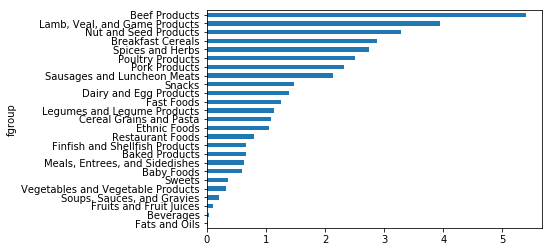

In [133]:
# 根据营养分类得出锌的中位数
result = ndata.groupby(['nutrient', 'fgroup'])['value'].quantile(0.5)
result['Zinc, Zn'].sort_values().plot(kind='barh')

In [134]:
# 找出个营养成分最丰富的食物
by_nutrient = ndata.groupby(['ngroup', 'nutrient'])

get_maximum = lambda x: x.xs(x.value.idxmax())
max_foods = by_nutrient.apply(get_maximum)[['value', 'food']]
max_foods.food = max_foods.food.str[:50]

max_foods.ix['Amino Acids']['food']

nutrient
Alanine                           Gelatins, dry powder, unsweetened
Arginine                               Seeds, sesame flour, low-fat
Aspartic acid                                   Soy protein isolate
Cystine                Seeds, cottonseed flour, low fat (glandless)
Glutamic acid                                   Soy protein isolate
Glycine                           Gelatins, dry powder, unsweetened
Histidine                Whale, beluga, meat, dried (Alaska Native)
Hydroxyproline    KENTUCKY FRIED CHICKEN, Fried Chicken, ORIGINA...
Isoleucine        Soy protein isolate, PROTEIN TECHNOLOGIES INTE...
Leucine           Soy protein isolate, PROTEIN TECHNOLOGIES INTE...
Lysine            Seal, bearded (Oogruk), meat, dried (Alaska Na...
Methionine                    Fish, cod, Atlantic, dried and salted
Phenylalanine     Soy protein isolate, PROTEIN TECHNOLOGIES INTE...
Proline                           Gelatins, dry powder, unsweetened
Serine            Soy protein isolate, 